# Deep learning MNIST

Experiments using deep learning on the MNIST data set.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import pickle, gzip, numpy

# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
#train_set, valid_set, test_set = pickle.load(f)
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [4]:
from sklearn.preprocessing import OneHotEncoder

def preprocess(data):
    X, y = data
    Y = OneHotEncoder().fit_transform(y.reshape(-1,1)).todense()
    X, Y, y = (_.astype(np.float32) for _ in (X, Y, y))
    return X, Y, y

In [5]:
Xtrain, Ytrain, ytrain = preprocess(train_set)
Xtest, Ytest, ytest = preprocess(test_set)

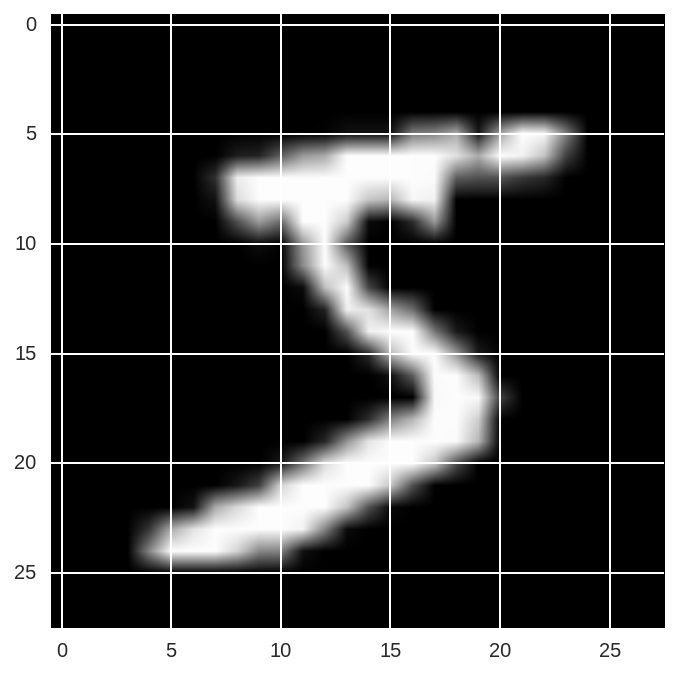

In [6]:
plt.imshow(Xtrain[0].reshape((28,28)), cmap=plt.cm.gray);

In [7]:
Ytrain[0]

matrix([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]], dtype=float32)

# Logistic regression

Probability distribution over $k$ classes modeled as
$p = \sigma (W^T x)$,
where $x$ is a $d$-dimensional feature vector, $W$ is a $d \times k$ matrix, and $\sigma$ is the softmax function.

In [8]:
import theano.tensor as T
from theano import config, function, shared
from theano.tensor.nnet import softmax
from numpy.random import uniform, rand

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled)


In [9]:
d = 784
k = 10

In [10]:
def sgd(cost, params, lr=0.05):
    """Stochastic gradient descent update"""
    grads = T.grad(cost, wrt=params)
    return [(p, p - lr*gp) for p, gp in zip(params, grads)]

In [11]:
X = T.matrix('X')
Y = T.matrix('Y')

# randomly initialize weights and biases
W = shared(uniform(-1, 1, size=(d, k)).astype(config.floatX), 'W')
b = shared(uniform(-1, 1, size=(k,  )).astype(config.floatX), 'b')

P = softmax(T.dot(X, W) + b)
pred = T.argmax(P, axis=1)
cost = -T.mean(T.sum(Y*T.log(P), axis=1))

train = function([X, Y], cost, updates=sgd(cost, [W, b]))
predict = function([X], pred)
predict_proba = function([X], P)

In [12]:
%%time
for i in range(101):
    c = train(Xtrain, Ytrain)
    if i % 10 == 0:
        accuracy = (ytrain == predict(Xtrain)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), accuracy))

epoch=0 cost=8.3071 accuracy=0.0896
epoch=10 cost=6.1089 accuracy=0.1032
epoch=20 cost=5.2902 accuracy=0.1263
epoch=30 cost=4.7341 accuracy=0.1613
epoch=40 cost=4.2839 accuracy=0.2015
epoch=50 cost=3.9056 accuracy=0.2410
epoch=60 cost=3.5848 accuracy=0.2779
epoch=70 cost=3.3110 accuracy=0.3120
epoch=80 cost=3.0760 accuracy=0.3416
epoch=90 cost=2.8733 accuracy=0.3694
epoch=100 cost=2.6976 accuracy=0.3943
CPU times: user 9.66 s, sys: 1.15 s, total: 10.8 s
Wall time: 10.8 s


In [13]:
(ytest == predict(Xtest)).mean()

0.40870000000000001

# Single hidden layer

In [14]:
from theano.tensor.nnet import relu

In [15]:
k0 = d  # input units
k1 = 25 # units in hidden layer
k2 = k  # output units

In [16]:
def init_weights(size, s=0.1):
    return uniform(low=-s, high=s, size=size).astype(config.floatX)

In [17]:
X = T.matrix('X')
Y = T.matrix('Y')

W0 = shared(init_weights((k0,k1)), 'W0')
W1 = shared(init_weights((k1,k2)), 'W1')

b0 = shared(np.zeros(k1), 'b0')
b1 = shared(np.zeros(k2), 'b1')

A0 = X
A1 = relu(T.dot(A0, W0) + b0) # rectifier activation function
A2 = softmax(T.dot(A1, W1) + b1)

P = A2
pred = T.argmax(P, axis=1)
cost = -T.mean(T.sum(Y*T.log(P), axis=1))

train = function([X, Y], cost, updates=sgd(cost, [W0, b0, W1, b1]))
predict = function([X], pred)
predict_proba = function([X], P)

In [18]:
%%time
for i in range(101):
    c = train(Xtrain, Ytrain)
    if i % 10 == 0:
        accuracy = (ytrain == predict(Xtrain)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), accuracy))

epoch=0 cost=2.3097 accuracy=0.1181
epoch=10 cost=2.2617 accuracy=0.2255
epoch=20 cost=2.2158 accuracy=0.3076
epoch=30 cost=2.1615 accuracy=0.3782
epoch=40 cost=2.0922 accuracy=0.4477
epoch=50 cost=2.0039 accuracy=0.5161
epoch=60 cost=1.8955 accuracy=0.5712
epoch=70 cost=1.7696 accuracy=0.6105
epoch=80 cost=1.6340 accuracy=0.6380
epoch=90 cost=1.4986 accuracy=0.6631
epoch=100 cost=1.3715 accuracy=0.6866
CPU times: user 15.9 s, sys: 17.8 s, total: 33.7 s
Wall time: 11.9 s


# RMSprop

Idea: Scale the gradient by a moving average of the magnitude of gradients in previous updates. Speeds up convergence when exploring flatter regions, increases stability in steep regions. 

In [19]:
def rmsprop(cost, params, lr=0.01, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = shared(p.get_value() * 0.) # trick to get 0 of correct type
        acc_new = rho*acc + (1-rho)*g**2
        scale = T.sqrt(acc_new + epsilon)
        g /= scale
        updates.append((acc, acc_new))
        updates.append((p, p - lr*g))
    return updates

In [20]:
train = function([X, Y], cost, updates=rmsprop(cost, [W0, b0, W1, b1]))

In [21]:
# reinitialize weights
W0.set_value(init_weights((k0, k1)))
b0.set_value(init_weights((k1,)))
W1.set_value(init_weights((k1, k2)))
b1.set_value(init_weights((k2,)))

In [22]:
%%time
for i in range(101):
    c = train(Xtrain, Ytrain)
    if i % 10 == 0:
        accuracy = (ytrain == predict(Xtrain)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), accuracy))

epoch=0 cost=2.3285 accuracy=0.3057
epoch=10 cost=0.8884 accuracy=0.7190
epoch=20 cost=0.6051 accuracy=0.8287
epoch=30 cost=0.4899 accuracy=0.8387
epoch=40 cost=0.4468 accuracy=0.8704
epoch=50 cost=0.4102 accuracy=0.8698
epoch=60 cost=0.3486 accuracy=0.8684
epoch=70 cost=0.3290 accuracy=0.9125
epoch=80 cost=0.2830 accuracy=0.9213
epoch=90 cost=0.3437 accuracy=0.9029
epoch=100 cost=0.2726 accuracy=0.9121
CPU times: user 16.6 s, sys: 17.5 s, total: 34.2 s
Wall time: 12.7 s


In [23]:
(ytest == predict(Xtest)).mean()

0.91510000000000002

In [24]:
(ytrain == predict(Xtrain)).mean()

0.91205999999999998

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

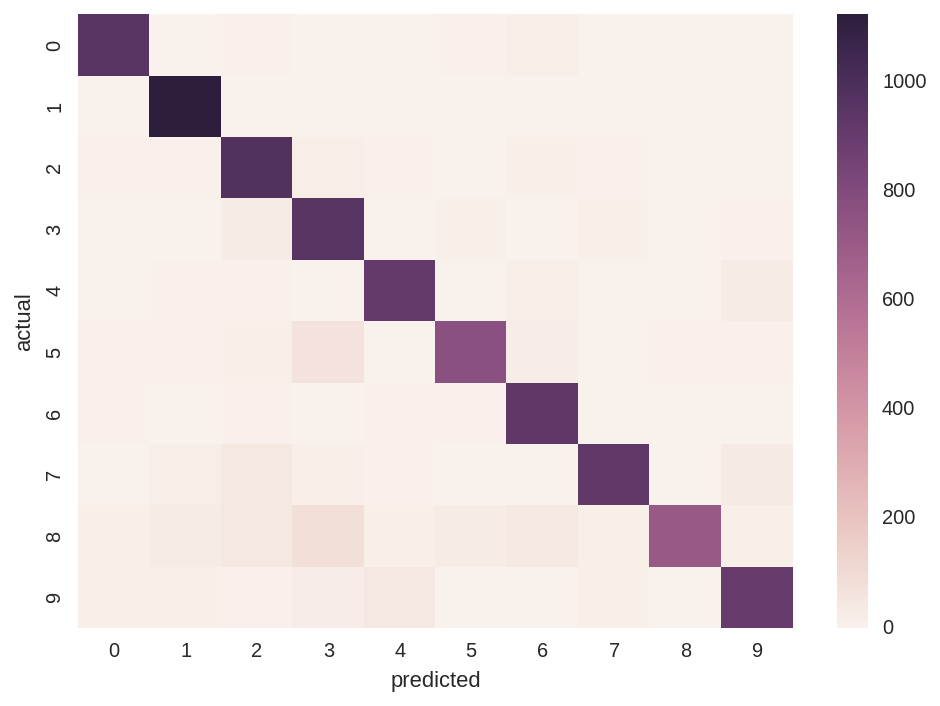

In [26]:
sns.heatmap(confusion_matrix(ytest, predict(Xtest)))
plt.xlabel('predicted')
plt.ylabel('actual');

# CNN (LeNet)

In [27]:
import theano
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

In [28]:
w0 = 28 # image size

In [29]:
Xtrain2d = Xtrain.reshape(-1, 1, w0, w0)
Xtrain2d.shape

(50000, 1, 28, 28)

In [30]:
l = 3 # kernel size
p = 2 # pool size

w1 = int((w0 - l + 1)/2) # size of image in layer 1
w2 = int((w1 - l + 1)/2) # etc.
w2

5

In [31]:
k0 = 1 # number of input channels (e.g. grayscale -> 1)
k1 = 4 # number of kernels in the first layer
k2 = 6 # etc...
k3 = k # number of output units

In [32]:
def init_weights_as(size):
    """Initialize random weights with scale recommended by Bengio et al."""
    b = np.sqrt(6/sum(size[:2]))
    return uniform(low=-b, high=b, size=size).astype(config.floatX)

In [33]:
X = T.tensor4('X')
Y = T.matrix('Y')

# weights for convolutional layers: 4-tensor per layer with
# shape = (num_kernels = num_output_feature_maps, 
#          num_input_feature_maps,
#          kernel_width, 
#          kernel_height)
w0 = shared(init_weights_as((k1, k0, l, l)), 'w0')
w1 = shared(init_weights_as((k2, k1, l, l)), 'w1')

# weights for fully-connected layer
# num_inputs = num_input_feature_maps * feature_map_size**2
#            = k2 * w2**2
W2 = shared(init_weights_as((k2*w2**2, k3)), 'W2')

# biases
b0 = shared(np.zeros(k1, dtype=config.floatX))
b1 = shared(np.zeros(k2, dtype=config.floatX))
b2 = shared(np.zeros(k3, dtype=config.floatX))

A0 = X

# 1st convolution and downsampling
A1 = relu(conv2d(A0, w0) + b0.dimshuffle('x',0,'x','x'))
a1 = max_pool_2d(A1, (p,p), ignore_border=True)

# 2nd convolution and downsampling
A2 = relu(conv2d(a1, w1) + b1.dimshuffle('x',0,'x','x'))
a2 = max_pool_2d(A2, (p,p), ignore_border=True)
           
# fully-connected output layer
A3  = softmax(T.dot(a2.flatten(2), W2) + b2)
P = A3

# standard stuff
pred = T.argmax(P, axis=1)
cost = -T.mean(T.sum(Y*T.log(P), axis=1))
updates = rmsprop(cost, [w0, b0, w1, b1, W2, b2])
train = function([X, Y], cost, updates=updates)
predict = function([X], pred)
predict_proba = function([X], P)

In [34]:
%%time
for i in range(101):
    c = train(Xtrain2d, Ytrain)
    if i % 10 == 0:
        accuracy = (ytrain == predict(Xtrain2d)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), accuracy))

epoch=0 cost=5.5934 accuracy=0.0960
epoch=10 cost=1.1975 accuracy=0.6575
epoch=20 cost=0.7335 accuracy=0.7774
epoch=30 cost=0.5381 accuracy=0.8330
epoch=40 cost=0.4132 accuracy=0.8834
epoch=50 cost=0.4538 accuracy=0.8847
epoch=60 cost=0.3107 accuracy=0.8923
epoch=70 cost=0.3034 accuracy=0.9041
epoch=80 cost=0.2129 accuracy=0.9373
epoch=90 cost=0.1851 accuracy=0.9463
epoch=100 cost=0.2157 accuracy=0.9211
CPU times: user 53.6 s, sys: 7.53 s, total: 1min 1s
Wall time: 1min 1s
